In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

### Traditional NLP

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [3]:
df = pd.read_csv('twitter_training.csv')
df.head()

,id,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
print("Dataset Shape:", df.shape)
print("\nMissing Values Before Cleaning:")
print(df.isna().sum())

Dataset Shape: (198, 4)

Missing Values Before Cleaning:
id               0
entity           0
sentiment        0
Tweet content    0
dtype: int64


In [5]:
# Task 1: Data Cleaning and Preprocessing
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    try:
        text = str(text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters except basic punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
        # Convert to lowercase
        text = text.lower()
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""

In [6]:
# lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    try:
        text = clean_text(text)
        if not text.strip():
            return ""
        # Tokenize and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

In [7]:
# Apply preprocessing
print("\nPreprocessing text data...")
df['cleaned_text'] = df['Tweet content'].apply(preprocess_text)

# Handle missing values after cleaning
initial_count = len(df)
df = df[df['cleaned_text'].str.strip() != '']
df = df.dropna(subset=['sentiment'])
print(f"\nRemoved {initial_count - len(df)} rows with empty/missing data")


Preprocessing text data...

Removed 3 rows with empty/missing data


In [8]:
# Train-test split
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['sentiment'].astype(str)  # Ensure sentiment is string type
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Feature Extraction/ Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include bigrams
    min_df=5,            # Ignore terms that appear in fewer than 5 documents
    max_df=0.7           # Ignore terms that appear in more than 70% of documents
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Creating TF-IDF features...


In [10]:
# Model Building (Multinomial Naive Bayes)
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(alpha=0.1)  # Add smoothing
nb_classifier.fit(X_train_tfidf, y_train)

,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None


In [11]:
# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = nb_classifier.predict(X_test_tfidf)

print("\nModel Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Evaluation:
Accuracy: 0.897

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.69      0.82        13
    Positive       0.87      1.00      0.93        26

    accuracy                           0.90        39
   macro avg       0.93      0.85      0.87        39
weighted avg       0.91      0.90      0.89        39


Confusion Matrix:
[[ 9  4]
 [ 0 26]]


([0, 1], [Text(0, 0, 'Positive'), Text(1, 0, 'Negative')])

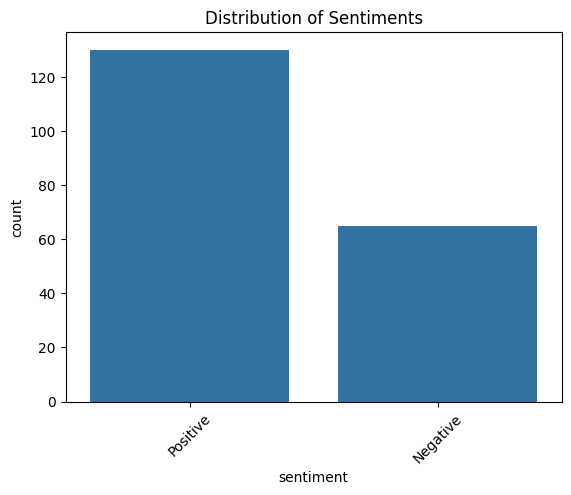

In [12]:
# Sentiment distribution
plt.plot(1, 2, 1)
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiments')
plt.xticks(rotation=45)

### Modern NLP

In [13]:
!pip install transformers tf-keras
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# 1: create pipeline for sentiment analysis
import torch

classification = pipeline('sentiment-analysis')
type(classification)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, s

transformers.pipelines.text_classification.TextClassificationPipeline

In [15]:
data = pd.read_csv("twitter_training.csv")
# set the columns
data.columns = ['id','entity','sentiment','Tweet content']

data = data.dropna()
data.head()

,id,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


<Axes: >

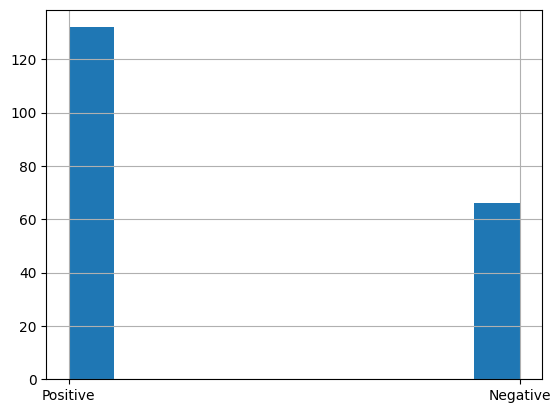

In [20]:
# required columns
data = data[['sentiment','Tweet content']]

data['sentiment'].hist() #check classes

In [21]:
target_map = { 'Positive': 1, 'Negative': 0}
data['target'] = data['sentiment'].map(target_map)

In [22]:
texts = data['Tweet content'].to_list()

In [23]:
import torch
torch.cuda.is_available()

predictions = classification(texts)

In [24]:
predictions[:10]

[{'label': 'NEGATIVE', 'score': 0.9834704995155334},
 {'label': 'POSITIVE', 'score': 0.9932871460914612},
 {'label': 'POSITIVE', 'score': 0.9783737659454346},
 {'label': 'NEGATIVE', 'score': 0.9768757820129395},
 {'label': 'POSITIVE', 'score': 0.7018892168998718},
 {'label': 'NEGATIVE', 'score': 0.9805620312690735},
 {'label': 'NEGATIVE', 'score': 0.7845375537872314},
 {'label': 'NEGATIVE', 'score': 0.9357832670211792},
 {'label': 'POSITIVE', 'score': 0.9987744688987732},
 {'label': 'NEGATIVE', 'score': 0.9372899532318115}]

In [26]:
probs = [d["score"] if d["label"].startswith("P") else 1 - d["score"] for d in predictions]

In [27]:
preds = [1 if d["label"].startswith("P") else 0 for d in predictions]

In [32]:
# accuracy = mean value of target values that are equal to preds
import numpy as np

preds = np.array(preds)
print("acc:", np.mean(data["target"] == preds))

acc: 0.803030303030303


#### Week 8 homework tasks:
- Topic modelling using traditional nlp
- Topic modelling using transformers
- Visualisations for sentiment analysis and topic modelling

- Further reading on LLMs

